In [49]:
from hamiltonian_nn.hnn import HNN                  # Sam Greydanus repo file
from hamiltonian_nn.nn_models import MLP            # 3-layer MLP the repo already uses
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gym
from torchvision import transforms
from PIL import Image, ImageDraw

In [50]:
def compute_energy(theta, omega, m=1.0, l=1.0, g=9.81):
    """
    Compute the total mechanical energy of the pendulum
    E = 0.5 * m * l^2 * omega^2 + m * g * l * (1 - cos(theta))
    """
    kinetic = 0.5 * m * (l**2) * omega**2
    potential = m * g * l * (1 - np.cos(theta))
    return kinetic + potential

In [51]:
def plot_energy_per_episode(dataset, episode_length=100):
    thetas = []
    omegas = []
    energies = []
    num_episodes = len(dataset) // episode_length

    for ep in range(num_episodes):
        ep_thetas = []
        ep_omegas = []
        for i in range(episode_length):
            idx = ep * episode_length + i
            _, label = dataset[idx]
            ep_thetas.append(label[0].item())
            ep_omegas.append(label[1].item())
        theta_np = np.array(ep_thetas)
        omega_np = np.array(ep_omegas)
        energy = compute_energy(theta_np, omega_np)
        energies.append(energy)

    # Plot each episode separately
    plt.figure(figsize=(12, 4))
    for ep_energy in energies:
        plt.plot(ep_energy, alpha=0.7)
    plt.xlabel("Time Step (within episode)")
    plt.ylabel("Energy (J)")
    plt.title("Pendulum Energy per Episode")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("energy_per_episode.png")
    plt.show()


In [52]:
def plot_true_phase_space(dataset, num_samples=500):
    theta_vals = []
    omega_vals = []
    for i in range(min(num_samples, len(dataset))):
        _, label = dataset[i]
        theta_vals.append(label[0].item())
        omega_vals.append(label[1].item())

    plt.figure(figsize=(6, 5))
    plt.plot(theta_vals, omega_vals, '.', alpha=0.3)
    plt.xlabel("Theta (rad)")
    plt.ylabel("Theta dot (rad/s)")
    plt.title("True Phase Space Trajectory (θ vs θ̇)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("true_phase_space.png")
    plt.show()

In [53]:
def analyze_vjepa_latent_phase_relation(model, dataset, batch_size=64, num_samples=500):
    """
    Analyze how V-JEPA latent embeddings relate to physical phase space variables (theta, theta_dot).
    This assumes access to the latent features before the prediction head.

    Args:
        model: trained V-JEPA model
        dataset: PendulumDataset object with access to raw images and (theta, omega) tuples
        batch_size: batch size for DataLoader
        num_samples: number of samples to analyze
    """
    model.eval()

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    latent_features = []
    theta_list = []
    omega_list = []

    count = 0
    for imgs, labels in tqdm(loader, desc="Extracting embeddings"):
        imgs = imgs.to(next(model.parameters()).device)
        thetas, omegas = labels[:, 0], labels[:, 1]

        with torch.no_grad():
            x = model.patch_embed(imgs) + model.pos_embed  # [B, N, D]
            x = model.context_encoder(x)  # [B, N, D]
            pooled = x.mean(dim=1)  # average pooling over patches -> [B, D]
            latent_features.append(pooled.cpu())

        theta_list.extend(thetas.numpy())
        omega_list.extend(omegas.numpy())

        count += imgs.size(0)
        if count >= num_samples:
            break

    latent_features = torch.cat(latent_features, dim=0).numpy()[:num_samples]
    theta_array = np.array(theta_list[:num_samples]).reshape(-1, 1)
    omega_array = np.array(omega_list[:num_samples]).reshape(-1, 1)

    # Fit regressors
    reg_theta = LinearRegression().fit(latent_features, theta_array)
    reg_omega = LinearRegression().fit(latent_features, omega_array)

    theta_pred = reg_theta.predict(latent_features)
    omega_pred = reg_omega.predict(latent_features)

    # Metrics
    r2_theta = r2_score(theta_array, theta_pred)
    r2_omega = r2_score(omega_array, omega_pred)
    mse_theta = mean_squared_error(theta_array, theta_pred)
    mse_omega = mean_squared_error(omega_array, omega_pred)

    print(f"\nLatent -> Theta R²: {r2_theta:.4f}, MSE: {mse_theta:.4f}")
    print(f"Latent -> Omega R²: {r2_omega:.4f}, MSE: {mse_omega:.4f}")

    # Scatter plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(theta_array, theta_pred, alpha=0.6)
    plt.xlabel("True θ")
    plt.ylabel("Predicted θ from Latents")
    plt.title("Latent Embedding → Theta")

    plt.subplot(1, 2, 2)
    plt.scatter(omega_array, omega_pred, alpha=0.6)
    plt.xlabel("True θ̇")
    plt.ylabel("Predicted θ̇ from Latents")
    plt.title("Latent Embedding → Theta_dot")

    plt.tight_layout()
    plt.show()


In [54]:
def plot_energy_conservation(dataset, dt=0.05, m=1.0, l=1.0, g=9.81):
    """
    Plot total mechanical energy vs. time (seconds).

    • Works with the original PendulumDataset (attributes .labels)
      *and* with the windowed version that stores .states.

    • dt – time delta between successive frames; Gym's pendulum uses
      0.05 s by default.
    """
    import numpy as np, matplotlib.pyplot as plt

    # -------- pull θ and θ̇ from whichever attr exists -------------
    if hasattr(dataset, "states"):               # windowed version
        data = np.asarray(dataset.states)        # (N,2)
    elif hasattr(dataset, "labels"):             # flat version
        data = np.asarray(dataset.labels)
    else:
        # fallback: iterate through dataset
        data = np.concatenate([dataset[i][1].numpy() for i in range(len(dataset))])

    theta, theta_dot = data[:,0], data[:,1]

    # -------- energy ----------------------------------------------
    kinetic   = 0.5 * m * (l**2) * theta_dot**2          # ½ m (l θ̇)²
    potential = m * g * l * (1 - np.cos(theta))
    E_total   = kinetic + potential

    # -------- time axis in seconds -------------------------------
    t = np.arange(len(E_total)) * dt

    # -------- plot ------------------------------------------------
    plt.figure(figsize=(10,4))
    plt.plot(t, E_total, lw=1.0, label="Total Energy")
    plt.xlabel("time  [s]")
    plt.ylabel("energy  [J]")
    plt.title("Pendulum energy (ground-truth)")
    plt.grid(True); plt.tight_layout(); plt.legend()
    plt.show()

Using device: cpu
Generating synthetic pendulum data...


  0%|          | 0/50 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 50/50 [00:00<00:00, 167.62it/s]


Dataset created with 5000 images
Starting training…


Epoch 1/10:   1%|          | 1/157 [00:01<03:42,  1.42s/batch]

  step 0000  jepa 6.6719  phys 12.3256


Epoch 1/10:   7%|▋         | 11/157 [00:12<02:36,  1.08s/batch]

  step 0010  jepa 4.0869  phys 13.2601


Epoch 1/10:  13%|█▎        | 21/157 [00:22<02:24,  1.06s/batch]

  step 0020  jepa 3.7140  phys 7.4312


Epoch 1/10:  20%|█▉        | 31/157 [00:34<02:18,  1.10s/batch]

  step 0030  jepa 3.2910  phys 13.0277


Epoch 1/10:  26%|██▌       | 41/157 [00:45<02:04,  1.07s/batch]

  step 0040  jepa 2.8998  phys 11.5840


Epoch 1/10:  32%|███▏      | 51/157 [00:56<01:57,  1.11s/batch]

  step 0050  jepa 2.5192  phys 8.9082


Epoch 1/10:  39%|███▉      | 61/157 [01:06<01:39,  1.03s/batch]

  step 0060  jepa 2.1686  phys 10.4867


Epoch 1/10:  45%|████▌     | 71/157 [01:17<01:27,  1.01s/batch]

  step 0070  jepa 1.8858  phys 9.5883


Epoch 1/10:  52%|█████▏    | 81/157 [01:27<01:19,  1.05s/batch]

  step 0080  jepa 1.6900  phys 8.7502


Epoch 1/10:  58%|█████▊    | 91/157 [01:37<01:07,  1.02s/batch]

  step 0090  jepa 1.5372  phys 10.6461


Epoch 1/10:  64%|██████▍   | 101/157 [01:48<00:57,  1.03s/batch]

  step 0100  jepa 1.4463  phys 10.1834


Epoch 1/10:  71%|███████   | 111/157 [01:58<00:49,  1.08s/batch]

  step 0110  jepa 1.3742  phys 12.8607


Epoch 1/10:  77%|███████▋  | 121/157 [02:09<00:39,  1.10s/batch]

  step 0120  jepa 1.3276  phys 7.8986


Epoch 1/10:  83%|████████▎ | 131/157 [02:21<00:31,  1.21s/batch]

  step 0130  jepa 1.2996  phys 11.2996


Epoch 1/10:  90%|████████▉ | 141/157 [02:33<00:18,  1.15s/batch]

  step 0140  jepa 1.2810  phys 12.5883


Epoch 1/10:  96%|█████████▌| 151/157 [02:47<00:09,  1.51s/batch]

  step 0150  jepa 1.2732  phys 9.2862


Epoch 1/10: 100%|██████████| 157/157 [02:54<00:00,  1.11s/batch]


Epoch 1 complete — avg loss 2.2683


Epoch 2/10:   1%|          | 1/157 [00:01<05:07,  1.97s/batch]

  step 0000  jepa 1.2460  phys 9.0716


Epoch 2/10:   7%|▋         | 11/157 [00:16<03:27,  1.42s/batch]

  step 0010  jepa 1.2420  phys 14.0685


Epoch 2/10:  13%|█▎        | 21/157 [00:28<02:38,  1.17s/batch]

  step 0020  jepa 1.2274  phys 13.9475


Epoch 2/10:  20%|█▉        | 31/157 [00:38<02:16,  1.08s/batch]

  step 0030  jepa 1.2228  phys 11.2139


Epoch 2/10:  26%|██▌       | 41/157 [00:48<01:54,  1.01batch/s]

  step 0040  jepa 1.2117  phys 11.9111


Epoch 2/10:  32%|███▏      | 51/157 [00:59<01:47,  1.01s/batch]

  step 0050  jepa 1.2162  phys 7.7874


Epoch 2/10:  39%|███▉      | 61/157 [01:09<01:34,  1.02batch/s]

  step 0060  jepa 1.1886  phys 7.4216


Epoch 2/10:  45%|████▌     | 71/157 [01:18<01:23,  1.03batch/s]

  step 0070  jepa 1.1959  phys 10.7697


Epoch 2/10:  52%|█████▏    | 81/157 [01:29<01:15,  1.00batch/s]

  step 0080  jepa 1.1627  phys 9.9499


Epoch 2/10:  58%|█████▊    | 91/157 [01:38<01:04,  1.02batch/s]

  step 0090  jepa 1.1452  phys 12.4663


Epoch 2/10:  64%|██████▍   | 101/157 [01:48<00:55,  1.01batch/s]

  step 0100  jepa 1.1447  phys 6.8541


Epoch 2/10:  71%|███████   | 111/157 [01:58<00:46,  1.02s/batch]

  step 0110  jepa 1.1329  phys 12.4271


Epoch 2/10:  77%|███████▋  | 121/157 [02:08<00:35,  1.01batch/s]

  step 0120  jepa 1.1199  phys 12.2101


Epoch 2/10:  83%|████████▎ | 131/157 [02:18<00:25,  1.04batch/s]

  step 0130  jepa 1.1176  phys 10.1023


Epoch 2/10:  90%|████████▉ | 141/157 [02:28<00:16,  1.01s/batch]

  step 0140  jepa 1.1124  phys 12.3980


Epoch 2/10:  96%|█████████▌| 151/157 [02:38<00:06,  1.06s/batch]

  step 0150  jepa 1.0970  phys 12.3022


Epoch 2/10: 100%|██████████| 157/157 [02:43<00:00,  1.04s/batch]


Epoch 2 complete — avg loss 1.1869


Epoch 3/10:   1%|          | 1/157 [00:01<02:51,  1.10s/batch]

  step 0000  jepa 1.1266  phys 14.1754


Epoch 3/10:   7%|▋         | 11/157 [00:12<02:48,  1.15s/batch]

  step 0010  jepa 1.0900  phys 16.9918


Epoch 3/10:  13%|█▎        | 21/157 [00:23<02:33,  1.13s/batch]

  step 0020  jepa 1.1016  phys 4.5138


Epoch 3/10:  20%|█▉        | 31/157 [00:34<02:23,  1.14s/batch]

  step 0030  jepa 1.0879  phys 9.4352


Epoch 3/10:  26%|██▌       | 41/157 [00:44<01:52,  1.03batch/s]

  step 0040  jepa 1.0718  phys 12.3403


Epoch 3/10:  32%|███▏      | 51/157 [00:53<01:42,  1.04batch/s]

  step 0050  jepa 1.0903  phys 11.3516


Epoch 3/10:  39%|███▉      | 61/157 [01:03<01:31,  1.05batch/s]

  step 0060  jepa 1.0671  phys 11.7135


Epoch 3/10:  45%|████▌     | 71/157 [01:12<01:21,  1.05batch/s]

  step 0070  jepa 1.0683  phys 11.4800


Epoch 3/10:  52%|█████▏    | 81/157 [01:22<01:14,  1.02batch/s]

  step 0080  jepa 1.0681  phys 12.5892


Epoch 3/10:  58%|█████▊    | 91/157 [01:32<01:05,  1.01batch/s]

  step 0090  jepa 1.0774  phys 10.7714


Epoch 3/10:  64%|██████▍   | 101/157 [01:42<00:54,  1.03batch/s]

  step 0100  jepa 1.0732  phys 6.6960


Epoch 3/10:  71%|███████   | 111/157 [01:55<00:57,  1.25s/batch]

  step 0110  jepa 1.0581  phys 9.7905


Epoch 3/10:  77%|███████▋  | 121/157 [02:06<00:42,  1.18s/batch]

  step 0120  jepa 1.0718  phys 11.5851


Epoch 3/10:  83%|████████▎ | 131/157 [02:18<00:31,  1.22s/batch]

  step 0130  jepa 1.0643  phys 10.9142


Epoch 3/10:  90%|████████▉ | 141/157 [02:31<00:18,  1.15s/batch]

  step 0140  jepa 1.0595  phys 10.3814


Epoch 3/10:  96%|█████████▌| 151/157 [02:42<00:06,  1.11s/batch]

  step 0150  jepa 1.0693  phys 8.6832


Epoch 3/10: 100%|██████████| 157/157 [02:48<00:00,  1.07s/batch]


Epoch 3 complete — avg loss 1.0880


Epoch 4/10:   1%|          | 1/157 [00:01<02:44,  1.06s/batch]

  step 0000  jepa 1.0722  phys 11.5175


Epoch 4/10:   7%|▋         | 11/157 [00:11<02:35,  1.06s/batch]

  step 0010  jepa 1.0712  phys 11.3186


Epoch 4/10:  13%|█▎        | 21/157 [00:22<02:25,  1.07s/batch]

  step 0020  jepa 1.0608  phys 9.7105


Epoch 4/10:  20%|█▉        | 31/157 [00:33<02:21,  1.12s/batch]

  step 0030  jepa 1.0535  phys 13.5485


Epoch 4/10:  26%|██▌       | 41/157 [00:44<02:10,  1.13s/batch]

  step 0040  jepa 1.0591  phys 10.6400


Epoch 4/10:  32%|███▏      | 51/157 [00:55<01:53,  1.07s/batch]

  step 0050  jepa 1.0581  phys 13.3450


Epoch 4/10:  39%|███▉      | 61/157 [01:06<01:43,  1.08s/batch]

  step 0060  jepa 1.0546  phys 10.4521


Epoch 4/10:  45%|████▌     | 71/157 [01:17<01:32,  1.08s/batch]

  step 0070  jepa 1.0441  phys 11.1648


Epoch 4/10:  52%|█████▏    | 81/157 [01:28<01:22,  1.08s/batch]

  step 0080  jepa 1.0628  phys 7.0489


Epoch 4/10:  58%|█████▊    | 91/157 [01:39<01:11,  1.09s/batch]

  step 0090  jepa 1.0518  phys 9.6488


Epoch 4/10:  64%|██████▍   | 101/157 [01:49<00:59,  1.06s/batch]

  step 0100  jepa 1.0525  phys 10.8549


Epoch 4/10:  71%|███████   | 111/157 [02:00<00:51,  1.12s/batch]

  step 0110  jepa 1.0492  phys 13.5018


Epoch 4/10:  77%|███████▋  | 121/157 [02:11<00:39,  1.08s/batch]

  step 0120  jepa 1.0514  phys 11.5864


Epoch 4/10:  83%|████████▎ | 131/157 [02:22<00:27,  1.06s/batch]

  step 0130  jepa 1.0497  phys 8.2589


Epoch 4/10:  90%|████████▉ | 141/157 [02:33<00:17,  1.12s/batch]

  step 0140  jepa 1.0473  phys 9.4524


Epoch 4/10:  96%|█████████▌| 151/157 [02:44<00:06,  1.06s/batch]

  step 0150  jepa 1.0470  phys 11.2260


Epoch 4/10: 100%|██████████| 157/157 [02:50<00:00,  1.08s/batch]


Epoch 4 complete — avg loss 1.0655


Epoch 5/10:   1%|          | 1/157 [00:01<02:57,  1.14s/batch]

  step 0000  jepa 1.0462  phys 7.3845


Epoch 5/10:   7%|▋         | 11/157 [00:11<02:37,  1.08s/batch]

  step 0010  jepa 1.0400  phys 11.7678


Epoch 5/10:  13%|█▎        | 21/157 [00:22<02:30,  1.11s/batch]

  step 0020  jepa 1.0482  phys 11.1265


Epoch 5/10:  20%|█▉        | 31/157 [00:33<02:13,  1.06s/batch]

  step 0030  jepa 1.0462  phys 11.6506


Epoch 5/10:  26%|██▌       | 41/157 [00:44<02:06,  1.09s/batch]

  step 0040  jepa 1.0411  phys 11.4768


Epoch 5/10:  32%|███▏      | 51/157 [00:57<02:07,  1.20s/batch]

  step 0050  jepa 1.0414  phys 10.8721


Epoch 5/10:  39%|███▉      | 61/157 [01:08<01:45,  1.10s/batch]

  step 0060  jepa 1.0400  phys 9.6599


Epoch 5/10:  45%|████▌     | 71/157 [01:19<01:33,  1.09s/batch]

  step 0070  jepa 1.0448  phys 13.4858


Epoch 5/10:  52%|█████▏    | 81/157 [01:30<01:21,  1.08s/batch]

  step 0080  jepa 1.0435  phys 13.0082


Epoch 5/10:  58%|█████▊    | 91/157 [01:41<01:10,  1.07s/batch]

  step 0090  jepa 1.0407  phys 8.3798


Epoch 5/10:  64%|██████▍   | 101/157 [01:51<00:59,  1.07s/batch]

  step 0100  jepa 1.0359  phys 6.1212


Epoch 5/10:  71%|███████   | 111/157 [02:02<00:50,  1.10s/batch]

  step 0110  jepa 1.0390  phys 9.7540


Epoch 5/10:  77%|███████▋  | 121/157 [02:13<00:38,  1.06s/batch]

  step 0120  jepa 1.0436  phys 8.1508


Epoch 5/10:  83%|████████▎ | 131/157 [02:24<00:27,  1.07s/batch]

  step 0130  jepa 1.0370  phys 11.5755


Epoch 5/10:  90%|████████▉ | 141/157 [02:34<00:16,  1.05s/batch]

  step 0140  jepa 1.0378  phys 12.2272


Epoch 5/10:  96%|█████████▌| 151/157 [02:45<00:06,  1.10s/batch]

  step 0150  jepa 1.0408  phys 10.1152


Epoch 5/10: 100%|██████████| 157/157 [02:51<00:00,  1.09s/batch]


Epoch 5 complete — avg loss 1.0541


Epoch 6/10:   1%|          | 1/157 [00:01<03:02,  1.17s/batch]

  step 0000  jepa 1.0380  phys 10.2175


Epoch 6/10:   7%|▋         | 11/157 [00:12<02:41,  1.10s/batch]

  step 0010  jepa 1.0413  phys 12.0913


Epoch 6/10:  13%|█▎        | 21/157 [00:22<02:24,  1.06s/batch]

  step 0020  jepa 1.0415  phys 11.8480


Epoch 6/10:  20%|█▉        | 31/157 [00:33<02:15,  1.08s/batch]

  step 0030  jepa 1.0378  phys 9.7706


Epoch 6/10:  26%|██▌       | 41/157 [00:44<02:03,  1.07s/batch]

  step 0040  jepa 1.0453  phys 10.7209


Epoch 6/10:  32%|███▏      | 51/157 [00:55<02:00,  1.14s/batch]

  step 0050  jepa 1.0407  phys 9.4096


Epoch 6/10:  39%|███▉      | 61/157 [01:06<01:42,  1.06s/batch]

  step 0060  jepa 1.0366  phys 15.5229


Epoch 6/10:  45%|████▌     | 71/157 [01:16<01:33,  1.08s/batch]

  step 0070  jepa 1.0342  phys 10.2778


Epoch 6/10:  52%|█████▏    | 81/157 [01:28<01:23,  1.09s/batch]

  step 0080  jepa 1.0289  phys 11.2587


Epoch 6/10:  58%|█████▊    | 91/157 [01:38<01:12,  1.09s/batch]

  step 0090  jepa 1.0356  phys 10.9422


Epoch 6/10:  64%|██████▍   | 101/157 [01:49<00:59,  1.06s/batch]

  step 0100  jepa 1.0367  phys 8.0818


Epoch 6/10:  71%|███████   | 111/157 [02:01<00:54,  1.18s/batch]

  step 0110  jepa 1.0337  phys 12.3988


Epoch 6/10:  77%|███████▋  | 121/157 [02:12<00:38,  1.06s/batch]

  step 0120  jepa 1.0258  phys 7.8127


Epoch 6/10:  83%|████████▎ | 131/157 [02:23<00:28,  1.08s/batch]

  step 0130  jepa 1.0367  phys 12.2130


Epoch 6/10:  90%|████████▉ | 141/157 [02:34<00:16,  1.05s/batch]

  step 0140  jepa 1.0360  phys 10.5792


Epoch 6/10:  96%|█████████▌| 151/157 [02:46<00:06,  1.11s/batch]

  step 0150  jepa 1.0284  phys 7.4713


Epoch 6/10: 100%|██████████| 157/157 [02:52<00:00,  1.10s/batch]


Epoch 6 complete — avg loss 1.0460


Epoch 7/10:   1%|          | 1/157 [00:01<04:13,  1.63s/batch]

  step 0000  jepa 1.0431  phys 11.2365


Epoch 7/10:   7%|▋         | 11/157 [00:12<02:35,  1.07s/batch]

  step 0010  jepa 1.0331  phys 10.8360


Epoch 7/10:  13%|█▎        | 21/157 [00:23<02:25,  1.07s/batch]

  step 0020  jepa 1.0257  phys 11.2207


Epoch 7/10:  20%|█▉        | 31/157 [00:34<02:21,  1.13s/batch]

  step 0030  jepa 1.0356  phys 8.0807


Epoch 7/10:  26%|██▌       | 41/157 [00:45<02:08,  1.11s/batch]

  step 0040  jepa 1.0221  phys 15.7621


Epoch 7/10:  32%|███▏      | 51/157 [00:56<01:54,  1.08s/batch]

  step 0050  jepa 1.0257  phys 6.1570


Epoch 7/10:  39%|███▉      | 61/157 [01:06<01:42,  1.06s/batch]

  step 0060  jepa 1.0312  phys 11.1997


Epoch 7/10:  45%|████▌     | 71/157 [01:17<01:35,  1.11s/batch]

  step 0070  jepa 1.0310  phys 9.5523


Epoch 7/10:  52%|█████▏    | 81/157 [01:28<01:20,  1.06s/batch]

  step 0080  jepa 1.0295  phys 9.2894


Epoch 7/10:  58%|█████▊    | 91/157 [01:38<01:09,  1.06s/batch]

  step 0090  jepa 1.0244  phys 8.6164


Epoch 7/10:  64%|██████▍   | 101/157 [01:49<01:00,  1.09s/batch]

  step 0100  jepa 1.0287  phys 9.0209


Epoch 7/10:  71%|███████   | 111/157 [02:00<00:50,  1.09s/batch]

  step 0110  jepa 1.0254  phys 9.7476


Epoch 7/10:  77%|███████▋  | 121/157 [02:10<00:37,  1.05s/batch]

  step 0120  jepa 1.0227  phys 13.0982


Epoch 7/10:  83%|████████▎ | 131/157 [02:21<00:27,  1.05s/batch]

  step 0130  jepa 1.0201  phys 8.9842


Epoch 7/10:  90%|████████▉ | 141/157 [02:32<00:17,  1.09s/batch]

  step 0140  jepa 1.0350  phys 12.0620


Epoch 7/10:  96%|█████████▌| 151/157 [02:43<00:06,  1.12s/batch]

  step 0150  jepa 1.0292  phys 10.0276


Epoch 7/10: 100%|██████████| 157/157 [02:50<00:00,  1.08s/batch]


Epoch 7 complete — avg loss 1.0410


Epoch 8/10:   1%|          | 1/157 [00:01<03:05,  1.19s/batch]

  step 0000  jepa 1.0212  phys 7.5363


Epoch 8/10:   7%|▋         | 11/157 [00:12<02:52,  1.18s/batch]

  step 0010  jepa 1.0236  phys 11.0872


Epoch 8/10:  13%|█▎        | 21/157 [00:24<02:29,  1.10s/batch]

  step 0020  jepa 1.0381  phys 14.2957


Epoch 8/10:  20%|█▉        | 31/157 [00:35<02:17,  1.09s/batch]

  step 0030  jepa 1.0267  phys 8.9899


Epoch 8/10:  26%|██▌       | 41/157 [00:46<02:06,  1.09s/batch]

  step 0040  jepa 1.0237  phys 12.9747


Epoch 8/10:  32%|███▏      | 51/157 [00:57<01:56,  1.10s/batch]

  step 0050  jepa 1.0367  phys 10.5294


Epoch 8/10:  39%|███▉      | 61/157 [01:08<01:47,  1.12s/batch]

  step 0060  jepa 1.0377  phys 9.1075


Epoch 8/10:  45%|████▌     | 71/157 [01:20<01:33,  1.08s/batch]

  step 0070  jepa 1.0277  phys 11.8933


Epoch 8/10:  52%|█████▏    | 81/157 [01:31<01:22,  1.09s/batch]

  step 0080  jepa 1.0287  phys 11.5392


Epoch 8/10:  58%|█████▊    | 91/157 [01:42<01:11,  1.09s/batch]

  step 0090  jepa 1.0292  phys 8.0013


Epoch 8/10:  64%|██████▍   | 101/157 [01:53<00:59,  1.07s/batch]

  step 0100  jepa 1.0282  phys 6.8192


Epoch 8/10:  71%|███████   | 111/157 [02:04<00:49,  1.07s/batch]

  step 0110  jepa 1.0335  phys 15.5938


Epoch 8/10:  77%|███████▋  | 121/157 [02:14<00:39,  1.09s/batch]

  step 0120  jepa 1.0193  phys 11.3366


Epoch 8/10:  83%|████████▎ | 131/157 [02:25<00:27,  1.07s/batch]

  step 0130  jepa 1.0271  phys 9.4911


Epoch 8/10:  90%|████████▉ | 141/157 [02:36<00:16,  1.05s/batch]

  step 0140  jepa 1.0315  phys 8.8115


Epoch 8/10:  96%|█████████▌| 151/157 [02:47<00:06,  1.10s/batch]

  step 0150  jepa 1.0280  phys 8.9088


Epoch 8/10: 100%|██████████| 157/157 [02:53<00:00,  1.10s/batch]


Epoch 8 complete — avg loss 1.0379


Epoch 9/10:   1%|          | 1/157 [00:01<03:01,  1.16s/batch]

  step 0000  jepa 1.0224  phys 12.2426


Epoch 9/10:   7%|▋         | 11/157 [00:12<02:35,  1.07s/batch]

  step 0010  jepa 1.0287  phys 11.6405


Epoch 9/10:  13%|█▎        | 21/157 [00:22<02:28,  1.09s/batch]

  step 0020  jepa 1.0259  phys 14.9273


Epoch 9/10:  20%|█▉        | 31/157 [00:34<02:25,  1.15s/batch]

  step 0030  jepa 1.0270  phys 12.9875


Epoch 9/10:  26%|██▌       | 41/157 [00:44<02:01,  1.05s/batch]

  step 0040  jepa 1.0332  phys 7.2703


Epoch 9/10:  32%|███▏      | 51/157 [00:55<01:52,  1.06s/batch]

  step 0050  jepa 1.0364  phys 10.2708


Epoch 9/10:  39%|███▉      | 61/157 [01:06<01:43,  1.08s/batch]

  step 0060  jepa 1.0238  phys 18.6964


Epoch 9/10:  45%|████▌     | 71/157 [01:17<01:33,  1.08s/batch]

  step 0070  jepa 1.0216  phys 11.9821


Epoch 9/10:  52%|█████▏    | 81/157 [01:27<01:21,  1.07s/batch]

  step 0080  jepa 1.0177  phys 6.6132


Epoch 9/10:  58%|█████▊    | 91/157 [01:38<01:11,  1.09s/batch]

  step 0090  jepa 1.0228  phys 10.0832


Epoch 9/10:  64%|██████▍   | 101/157 [01:50<01:04,  1.15s/batch]

  step 0100  jepa 1.0237  phys 9.3487


Epoch 9/10:  71%|███████   | 111/157 [02:03<00:53,  1.16s/batch]

  step 0110  jepa 1.0280  phys 10.6087


Epoch 9/10:  77%|███████▋  | 121/157 [02:14<00:41,  1.14s/batch]

  step 0120  jepa 1.0245  phys 9.2723


Epoch 9/10:  83%|████████▎ | 131/157 [02:25<00:28,  1.10s/batch]

  step 0130  jepa 1.0232  phys 10.6155


Epoch 9/10:  90%|████████▉ | 141/157 [02:36<00:17,  1.08s/batch]

  step 0140  jepa 1.0256  phys 6.7961


Epoch 9/10:  96%|█████████▌| 151/157 [02:47<00:06,  1.12s/batch]

  step 0150  jepa 1.0311  phys 13.3688


Epoch 9/10: 100%|██████████| 157/157 [02:53<00:00,  1.11s/batch]


Epoch 9 complete — avg loss 1.0358


Epoch 10/10:   1%|          | 1/157 [00:01<03:10,  1.22s/batch]

  step 0000  jepa 1.0161  phys 11.7880


Epoch 10/10:   7%|▋         | 11/157 [00:12<02:39,  1.09s/batch]

  step 0010  jepa 1.0215  phys 12.9596


Epoch 10/10:  13%|█▎        | 21/157 [00:23<02:26,  1.08s/batch]

  step 0020  jepa 1.0241  phys 16.7392


Epoch 10/10:  20%|█▉        | 31/157 [00:33<02:14,  1.07s/batch]

  step 0030  jepa 1.0217  phys 10.0704


Epoch 10/10:  26%|██▌       | 41/157 [00:46<02:17,  1.18s/batch]

  step 0040  jepa 1.0255  phys 11.4694


Epoch 10/10:  32%|███▏      | 51/157 [00:56<01:50,  1.05s/batch]

  step 0050  jepa 1.0197  phys 11.0035


Epoch 10/10:  39%|███▉      | 61/157 [01:07<01:40,  1.04s/batch]

  step 0060  jepa 1.0265  phys 11.1452


Epoch 10/10:  45%|████▌     | 71/157 [01:17<01:31,  1.07s/batch]

  step 0070  jepa 1.0191  phys 6.0114


Epoch 10/10:  52%|█████▏    | 81/157 [01:29<01:32,  1.22s/batch]

  step 0080  jepa 1.0239  phys 8.6501


Epoch 10/10:  58%|█████▊    | 91/157 [01:40<01:12,  1.10s/batch]

  step 0090  jepa 1.0233  phys 13.3010


Epoch 10/10:  64%|██████▍   | 101/157 [01:51<01:00,  1.08s/batch]

  step 0100  jepa 1.0238  phys 11.9008


Epoch 10/10:  71%|███████   | 111/157 [02:02<00:52,  1.14s/batch]

  step 0110  jepa 1.0190  phys 16.1739


Epoch 10/10:  77%|███████▋  | 121/157 [02:15<00:42,  1.17s/batch]

  step 0120  jepa 1.0143  phys 12.8257


Epoch 10/10:  83%|████████▎ | 131/157 [02:27<00:31,  1.19s/batch]

  step 0130  jepa 1.0175  phys 12.5528


Epoch 10/10:  90%|████████▉ | 141/157 [02:38<00:17,  1.09s/batch]

  step 0140  jepa 1.0274  phys 15.7173


Epoch 10/10:  96%|█████████▌| 151/157 [02:49<00:06,  1.07s/batch]

  step 0150  jepa 1.0209  phys 9.2740


Epoch 10/10: 100%|██████████| 157/157 [02:54<00:00,  1.11s/batch]


Epoch 10 complete — avg loss 1.0340


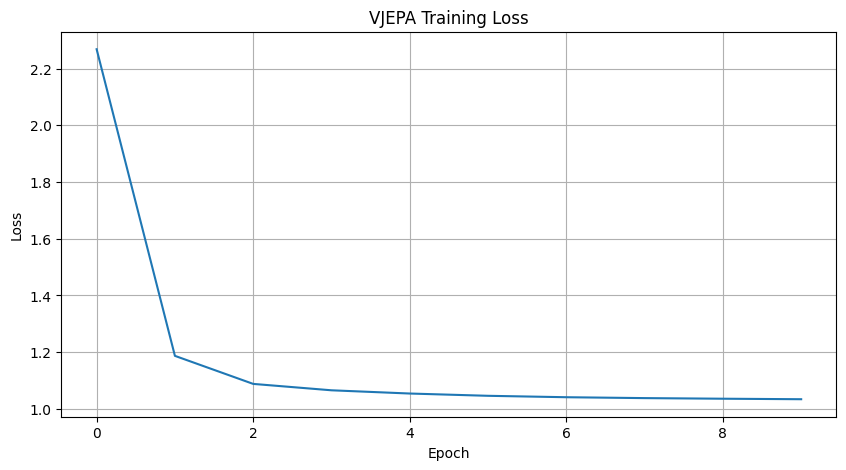

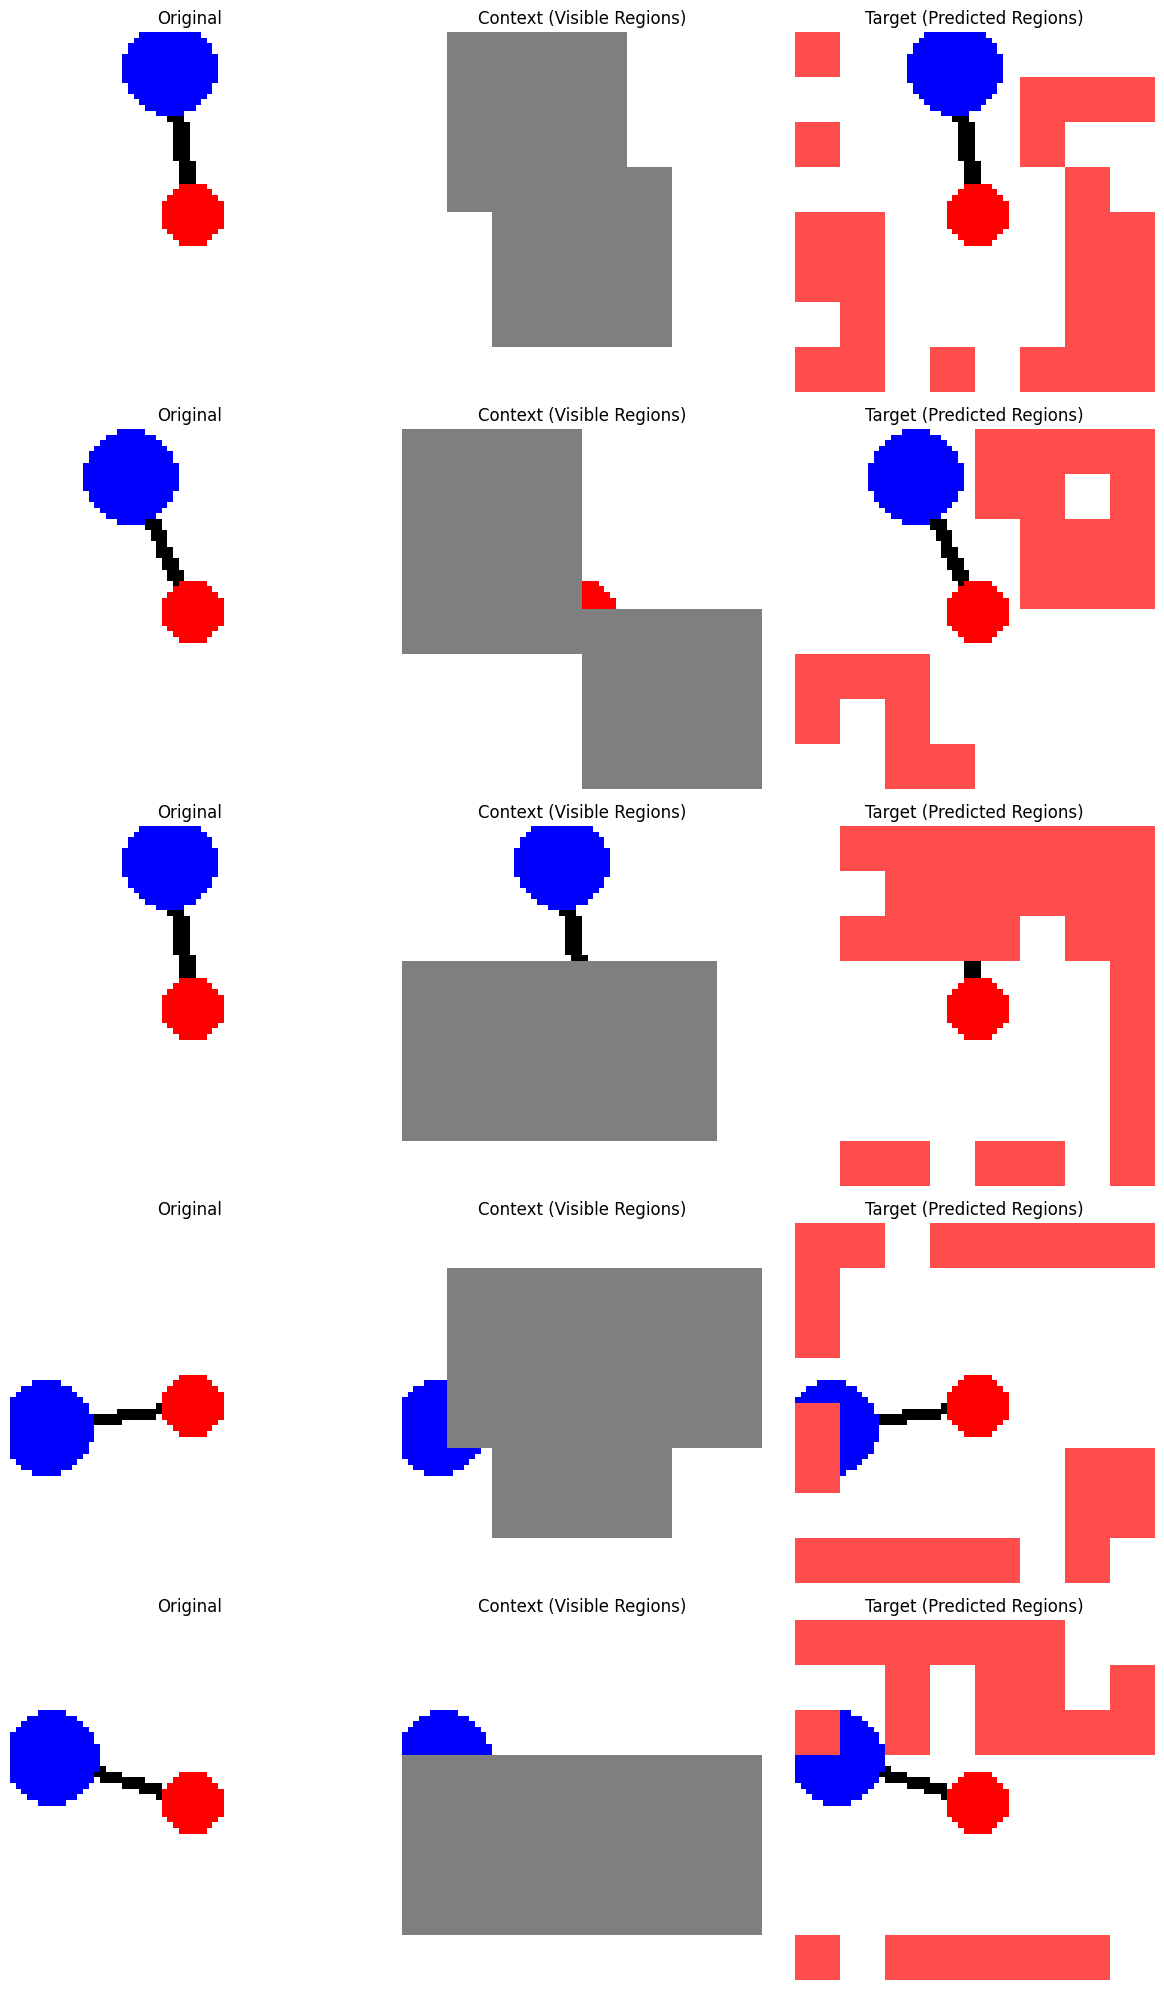

Training completed!


Extracting embeddings:   9%|▉         | 7/79 [00:01<00:12,  5.95it/s]



Latent -> Theta R²: 1.0000, MSE: 0.0001
Latent -> Omega R²: 0.2401, MSE: 7.2874


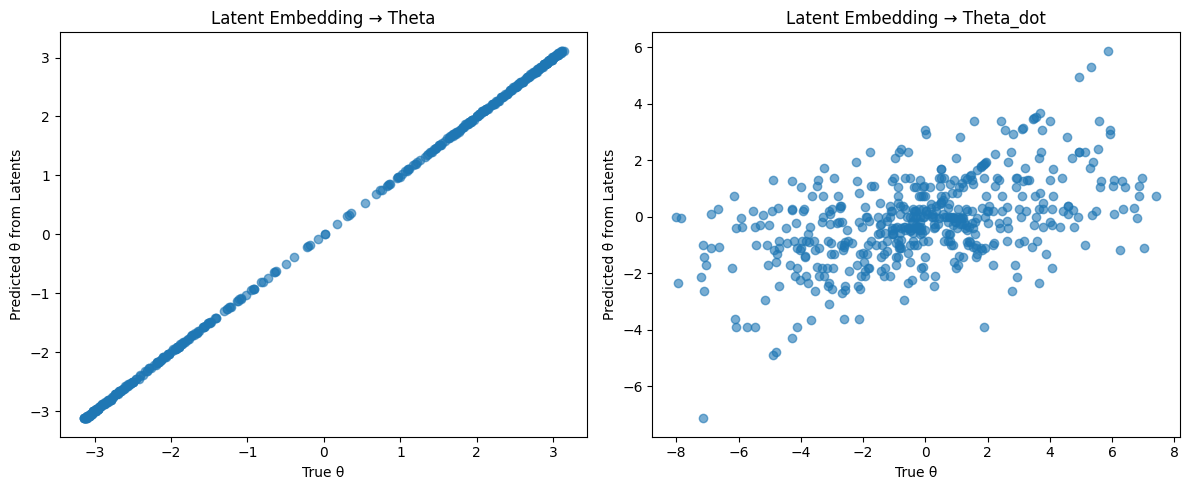

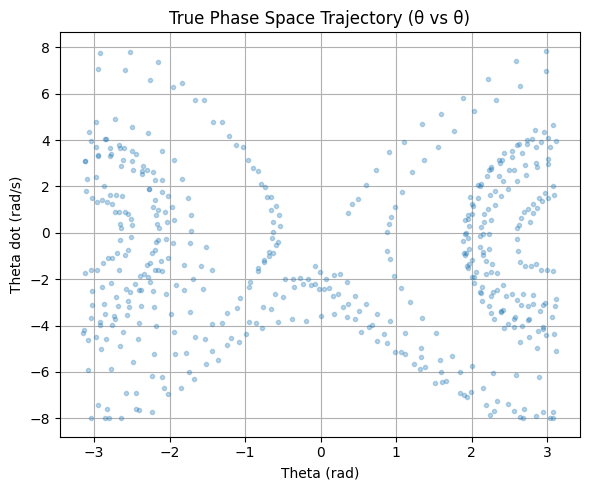

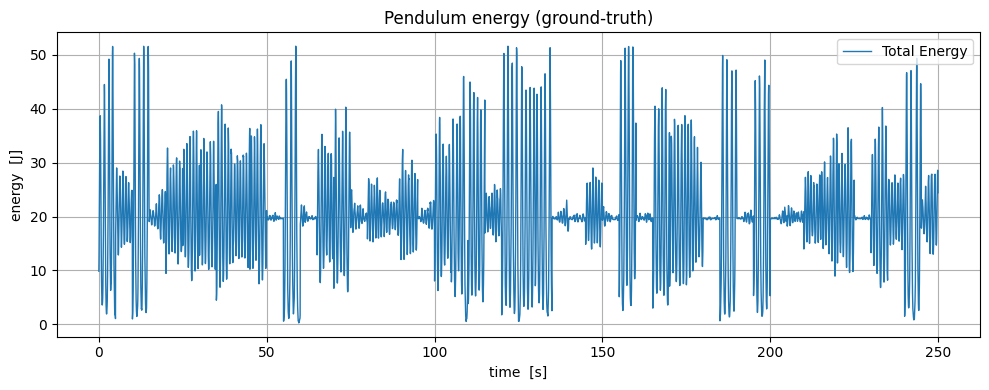

In [55]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Data Collection and Preparation
# ============================

class PendulumDataset(Dataset):
    def __init__(self, num_episodes=100, episode_length=200, img_size=64, transform=None):
        """
        Dataset for pendulum images from OpenAI Gym

        Args:
            num_episodes: Number of episodes to collect
            episode_length: Length of each episode
            img_size: Size to resize images to
            transform: Additional transforms to apply
        """
        self.img_size = img_size
        self.transform = transform

        # Generate synthetic pendulum images
        self.generate_synthetic_pendulum_data(num_episodes, episode_length)

    def generate_synthetic_pendulum_data(self, num_episodes, episode_length):
        """Generate synthetic pendulum data using PIL"""
        print("Generating synthetic pendulum data...")
        self.images = []

        # Create environment to get pendulum dynamics
        env = gym.make('Pendulum-v1')

        # Set up parameters for drawing pendulum
        img_size = self.img_size
        pendulum_length = img_size * 0.4
        center_x, center_y = img_size // 2, img_size // 2

        self.images = []
        self.labels = []

        for episode in tqdm(range(num_episodes)):
            # Reset environment
            obs = env.reset()
            if isinstance(obs, tuple):
                obs = obs[0]  # New API returns (obs, info)

            # Extract theta from observation
            # In Pendulum-v1, obs[0] = cos(theta), obs[1] = sin(theta)
            theta = np.arctan2(obs[1], obs[0])

            for step in range(episode_length):
                # Take random action
                action = env.action_space.sample()

                # Step the environment
                step_result = env.step(action)

                # Handle different Gym API versions
                if len(step_result) == 4:  # Old API
                    obs, reward, done, _ = step_result
                else:  # New API
                    obs, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated

                # Extract theta from observation
                theta = np.arctan2(obs[1], obs[0])
                omega = obs[2]

                # Draw pendulum image
                # Create a blank image
                img = Image.new('RGB', (img_size, img_size), color='white')
                draw = ImageDraw.Draw(img)

                # Calculate pendulum endpoint
                end_x = int(center_x + pendulum_length * np.sin(theta))
                end_y = int(center_y + pendulum_length * np.cos(theta))

                # Draw pendulum rod
                draw.line([(center_x, center_y), (end_x, end_y)], fill='black', width=3)

                # Draw pivot point
                draw.ellipse(
                    [(center_x-5, center_y-5), (center_x+5, center_y+5)],
                    fill='red'
                )

                # Draw bob
                draw.ellipse(
                    [(end_x-8, end_y-8), (end_x+8, end_y+8)],
                    fill='blue'
                )

                # Convert to numpy array
                img_array = np.array(img)

                # Add to dataset
                self.images.append(img_array)
                self.labels.append((theta, omega))

                if done:
                    break

        env.close()
        self.images = np.array(self.images)
        print(f"Dataset created with {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convert to tensor
        img = torch.from_numpy(img).float() / 255.0
        img = img.permute(2, 0, 1)  # Convert to CxHxW format

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.float32)

        return img, label

    def __len__(self):
        return len(self.images)

    # def __getitem__(self, idx):
    #     img = self.images[idx]

    #     # Convert to tensor
    #     img = torch.from_numpy(img).float() / 255.0
    #     img = img.permute(2, 0, 1)  # Convert to CxHxW format

    #     if self.transform:
    #         img = self.transform(img)

    #     return img

# ============================
# 2. VJEPA Architecture
# ============================

class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class TransformerEncoder(nn.Module):
    """
    Transformer encoder block
    """
    def __init__(self, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=int(embed_dim * mlp_ratio),
                batch_first=True,
                norm_first=True
            )
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MaskingStrategy:
    """
    Handles masked prediction strategies for JEPA/VJEPA
    """
    def __init__(self, num_patches, mask_ratio=0.75, block_size=4):
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio
        self.block_size = block_size

    def random_masking(self, batch_size):
        """Generate random masks for a batch"""
        n_keep = int(self.num_patches * (1 - self.mask_ratio))

        # For each sample, randomly select patches to keep
        noise = torch.rand(batch_size, self.num_patches, device=device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Determine which patches to keep
        mask = torch.ones([batch_size, self.num_patches], device=device)
        mask[:, :n_keep] = 0
        # Unshuffle to get the mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return mask.bool()  # masked positions are True

    def block_masking(self, batch_size):
        """Generate block-wise masks"""
        grid_size = int(np.sqrt(self.num_patches))

        # Create empty masks
        masks = torch.zeros(batch_size, self.num_patches, device=device)

        for b in range(batch_size):
            # Number of blocks to mask
            n_blocks = int((self.num_patches * self.mask_ratio) / (self.block_size**2))

            # Randomly choose block starting positions
            for _ in range(n_blocks):
                # Choose random top-left corner for block
                h_start = np.random.randint(0, grid_size - self.block_size + 1)
                w_start = np.random.randint(0, grid_size - self.block_size + 1)

                # Mask all patches in this block
                for h in range(h_start, h_start + self.block_size):
                    for w in range(w_start, w_start + self.block_size):
                        patch_idx = h * grid_size + w
                        masks[b, patch_idx] = 1

        return masks.bool()  # masked positions are True

class VJEPA(nn.Module):
    """
    Vision-based Joint Embedding Predictive Architecture
    """
    def __init__(
        self,
        img_size=64,
        patch_size=8,
        in_chans=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.0,
        prediction_head_dim=384
    ):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )

        # Number of patches
        self.num_patches = self.patch_embed.n_patches

        # Position embeddings
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches, embed_dim)
        )

        # Context encoder (f_θ)
        self.context_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio
        )

        # Target encoder (g_ϕ)
        self.target_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio
        )

        # Predictor network
        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, prediction_head_dim),
            nn.GELU(),
            nn.Linear(prediction_head_dim, embed_dim)
        )

        # Masking strategy
        self.masking = MaskingStrategy(self.num_patches)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize position embeddings
        nn.init.normal_(self.pos_embed, std=0.02)

        # Initialize projection layers
        self.apply(self._init_weights_layer)

    def _init_weights_layer(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    # def forward_context(self, imgs, context_mask):
    #     """Process the context (visible) regions"""
    #     # Get patch embeddings
    #     x = self.patch_embed(imgs)

    #     # Add position embeddings
    #     x = x + self.pos_embed

    #     # Get unmasked patches
    #     unmasked_indices = ~context_mask
    #     x_unmasked = x[unmasked_indices].reshape(imgs.shape[0], -1, x.shape[-1])

    #     # Encode context
    #     context_feats = self.context_encoder(x_unmasked)

    #     return context_feats
    def forward_context(self, imgs, context_mask):
      """Process the context (visible) regions"""
      # Get patch embeddings
      x = self.patch_embed(imgs)  # [B, num_patches, embed_dim]

      # Add positional embeddings
      x = x + self.pos_embed  # [B, num_patches, embed_dim]

      B, N, D = x.shape
      unmasked_indices = ~context_mask  # [B, num_patches]

      # Collect unmasked patches per sample
      x_unmasked = []

      for i in range(B):
          patches = x[i][unmasked_indices[i]]  # [num_unmasked_i, D]

          # Pad to the max number of patches in the batch
          num_unmasked = patches.shape[0]
          padded = F.pad(patches, (0, 0, 0, N - num_unmasked))  # [N, D]
          x_unmasked.append(padded)

      x_unmasked = torch.stack(x_unmasked)  # [B, N, D]

      # Optionally, create attention masks if Transformer should ignore padded tokens

      # Encode context
      context_feats = self.context_encoder(x_unmasked)  # [B, N, D]

      return context_feats


    def forward_target(self, imgs, target_mask):
        """Process the target (masked) regions"""
        # Get patch embeddings
        x = self.patch_embed(imgs)  # [B, num_patches, embed_dim]

        # Add positional embeddings
        x = x + self.pos_embed

        B, N, D = x.shape
        masked_indices = target_mask  # [B, num_patches]

        x_masked = []

        for i in range(B):
            patches = x[i][masked_indices[i]]  # [num_masked_i, D]

            # Pad to full length N
            num_masked = patches.shape[0]
            padded = F.pad(patches, (0, 0, 0, N - num_masked))  # [N, D]
            x_masked.append(padded)

        x_masked = torch.stack(x_masked)  # [B, N, D]

        # Encode masked regions (targets)
        target_feats = self.target_encoder(x_masked)

        return target_feats


    def forward(self, imgs):
        """
        Forward pass of VJEPA

        Args:
            imgs: Batch of images [B, C, H, W]

        Returns:
            loss: VJEPA loss value
            pred: Predicted embeddings
            target: Target embeddings
        """
        B = imgs.shape[0]

        # Generate masks for context and target
        context_mask = self.masking.block_masking(B)
        target_mask = self.masking.random_masking(B)

        # Ensure context and target don't overlap
        overlap_mask = context_mask & target_mask
        target_mask = target_mask & ~overlap_mask

        # Forward pass through context encoder
        context_feats = self.forward_context(imgs, context_mask)

        # Forward pass through target encoder
        with torch.no_grad():  # Stop gradient for target encoder
            target_feats = self.forward_target(imgs, target_mask)

        # Generate predictions from context
        pred = self.predictor(context_feats)

        # Compute loss
        loss = F.mse_loss(pred, target_feats)

        return loss, pred, target_feats

# ============================
# 3. Training Function
# ============================

def train_vjepa(model, theta_head, vec_field,
                train_loader, optimizer,
                num_epochs=100, log_interval=10,
                lambda_phys=1e-3, lambda_sup=1e-2):
    """
    Train VJEPA with an additional Hamiltonian physics loss.
    """
    model.train(); theta_head.train(); vec_field.train()
    losses = []

    print("Starting training…")
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for step, (imgs, labels) in enumerate(
                tqdm(train_loader, unit="batch",
                     desc=f"Epoch {epoch+1}/{num_epochs}")):

            imgs, labels = imgs.to(device), labels.to(device)   # labels = (θ, ω)

            # ─── 1. JEPA reconstruction loss ─────────────────────────
            loss_jepa, _, _ = model(imgs)

            # ─── 2. Latent → (θ̂ , ω̂)  (NO torch.no_grad!) ───────────
            lat = model.patch_embed(imgs) + model.pos_embed     # [B,N,D]
            lat = model.context_encoder(lat)                    # [B,N,D]
            z   = lat.mean(dim=1)                               # [B,D]
            theta_pred, omega_pred = theta_head(z).split(1, dim=1)  # [B,1] each

            # ─── 3. Physics loss  dq/dt ≈ ω_true ────────────────────
            state   = torch.cat([theta_pred, omega_pred], dim=1)      # [B,2]
            dqdt_pred = vec_field.time_derivative(state)[:, :1]       # (B,1)
            omega_true = labels[:, 1:2]                                # ω_true
            phys_loss  = F.mse_loss(dqdt_pred, omega_true)

            # optional direct θ supervision (helps the linear head converge)
            theta_true = labels[:, 0:1]
            sup_loss   = F.mse_loss(theta_pred, theta_true)

            # ─── 4. Total objective ─────────────────────────────────
            loss = loss_jepa + lambda_phys * phys_loss + lambda_sup * sup_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if step % log_interval == 0:
                tqdm.write(f"  step {step:04d}  "
                           f"jepa {loss_jepa.item():.4f}  "
                           f"phys {phys_loss.item():.4f}")

        avg = epoch_loss / len(train_loader)
        losses.append(avg)
        print(f"Epoch {epoch+1} complete — avg loss {avg:.4f}")

    return losses

# ============================
# 4. Visualization Functions
# ============================
def visualize_reconstructions(model, dataset, num_samples=5):
    """Visualize original images and their reconstructions"""
    model.eval()

    # Create a dataloader with batch size equal to num_samples
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    imgs, _ = next(iter(loader))  # <-- FIXED: unpack the tuple
    imgs = imgs.to(device)

    # Get reconstructions
    with torch.no_grad():
        # Generate masks
        B = imgs.shape[0]
        context_mask = model.masking.block_masking(B)
        target_mask = model.masking.random_masking(B)

        # Ensure no overlap
        overlap_mask = context_mask & target_mask
        target_mask = target_mask & ~overlap_mask

        # Get features
        context_feats = model.forward_context(imgs, context_mask)
        pred = model.predictor(context_feats)

    # Visualize the results
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        # Masked image (context)
        plt.subplot(num_samples, 3, i * 3 + 2)
        masked_img = imgs[i].clone().cpu()

        grid_size = int(np.sqrt(model.num_patches))
        mask_reshaped = context_mask[i].reshape(1, 1, grid_size, grid_size).float()
        mask_upsampled = F.interpolate(
            mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            masked_img[c][mask_upsampled.bool()] = 0.5  # Gray out masked areas

        plt.imshow(masked_img.permute(1, 2, 0).numpy())
        plt.title("Context (Visible Regions)")
        plt.axis('off')

        # Target image (highlight predicted regions)
        plt.subplot(num_samples, 3, i * 3 + 3)
        target_img = imgs[i].clone().cpu()

        target_mask_reshaped = target_mask[i].reshape(1, 1, grid_size, grid_size).float()
        target_mask_upsampled = F.interpolate(
            target_mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            if c == 0:  # Red channel
                target_img[c][target_mask_upsampled.bool()] = 1.0
            else:
                target_img[c][target_mask_upsampled.bool()] = 0.3

        plt.imshow(target_img.permute(1, 2, 0).numpy())
        plt.title("Target (Predicted Regions)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('vjepa_reconstructions.png')
    plt.show()


def plot_training_loss(losses):
    """Plot training loss over epochs"""
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('VJEPA Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('vjepa_training_loss.png')
    plt.show()

# ============================
# 5. Main Execution
# ============================

def main():
    # Configuration
    batch_size = 32
    img_size = 64
    patch_size = 8
    embed_dim = 384  # Smaller for faster training
    depth = 6  # Smaller depth for faster training
    num_heads = 6
    prediction_head_dim = 192
    learning_rate = 1e-4
    num_epochs = 10

    # Create dataset
    dataset = PendulumDataset(num_episodes=50, episode_length=100, img_size=img_size)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # Set num_workers=0 for compatibility

    # Create model
    model = VJEPA(
        img_size=img_size,
        patch_size=patch_size,
        in_chans=3,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads,
        decoder_embed_dim=embed_dim // 2,
        decoder_depth=4,
        decoder_num_heads=num_heads,
        mlp_ratio=4.0,
        prediction_head_dim=prediction_head_dim
    ).to(device)
    
    ######################################################################
    # (B)  immediately after you create the VJEPA model,                    │
    #      create a SINGLE linear mapping from latent → (θ̂ , ω̂).          │
    #      this will be trained jointly with V-JEPA and the HNN.            │
    ######################################################################
    latent_dim  = embed_dim              # = 384 in your config
    theta_head  = torch.nn.Linear(latent_dim, 2, bias=True).to(device)
    
    ######################################################################
    # (C)  instantiate an HNN ONCE  (again, right after model creation)
    ######################################################################
    vec_field = HNN(
        input_dim            = 2,            # (q, p)  where q = θ , p = ω
        differentiable_model = MLP(2, 256, 2),
        field_type           = 'solenoidal', # canonical Hamiltonian flow
        baseline             = False
    ).to(device)

    optimizer = optim.AdamW(
    list(model.parameters()) +
    list(theta_head.parameters()) +
    list(vec_field.parameters()),
    lr=learning_rate)

    # ------- training --------------------------------------------
    losses = train_vjepa(model, theta_head, vec_field,
                     train_loader, optimizer,
                     num_epochs=num_epochs)

    # Plot training loss
    plot_training_loss(losses)

    # Visualize reconstructions
    visualize_reconstructions(model, dataset)

    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, "vjepa_pendulum_final.pt")

    print("Training completed!")

    analyze_vjepa_latent_phase_relation(model,dataset )
    plot_true_phase_space(dataset)
    plot_energy_conservation(dataset)

if __name__ == "__main__":
    main()

In [ ]:
# ---------------------------------------------------------------
# Torch re-implementation of Miles Cranmer’s LNN (JAX → PyTorch)
# ---------------------------------------------------------------
class LNN(nn.Module):
    """
    Minimal PyTorch Lagrangian Neural Network.
    Learns a scalar L(q, v); returns Euler–Lagrange residual loss.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, qv):                    # (B, 2d) → scalar L
        return self.net(qv)

    def lagrangian_residual(self, q, v, dt=1.0):
        """
        q, v : (B, T, d)  – batch of trajectories (T≥2).
        Returns MSE of Euler–Lagrange residuals over B×(T-1) steps.
        """
        B, T, d = q.shape
        z   = torch.cat([q, v], dim=-1).reshape(B*T, -1).requires_grad_(True)
        L   = self.forward(z).sum()                    # scalar
        dLd  = torch.autograd.grad(L, z, create_graph=True)[0]
        dL_dq, dL_dv = dLd.split(d, dim=-1)
        dL_dq = dL_dq.reshape(B, T, d)
        dL_dv = dL_dv.reshape(B, T, d)

        # finite-difference time derivative of ∂L/∂v
        ddt_dLdv = (dL_dv[:,1:] - dL_dv[:,:-1]) / dt   # (B,T-1,d)
        res      = ddt_dLdv - dL_dq[:,:-1]             # (B,T-1,d)
        return (res**2).mean()

In [31]:
def analyze_vjepa_latent_phase_relation(model, dataset,
                                        batch_size=64, num_samples=500):
    """
    Regression of V-JEPA latent vectors → (theta, omega).
    Works with the sequence-dataset (T ≥ 2).
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    latents, theta_list, omega_list = [], [], []
    collected = 0

    for seq, states in tqdm(loader, desc="extract"):
        # seq  : (B,T,C,H,W)   – take first frame
        imgs = seq[:, 0].to(next(model.parameters()).device)  # (B,C,H,W)
        theta = states[:, 0, 0].numpy()   # true θ at t=0
        omega = states[:, 0, 1].numpy()   # true ω at t=0

        with torch.no_grad():
            x = model.patch_embed(imgs) + model.pos_embed        # (B,N,D)
            x = model.context_encoder(x)
            pooled = x.mean(1).cpu()                 # (B,D)

        latents.append(pooled)
        theta_list.extend(theta)
        omega_list.extend(omega)

        collected += imgs.size(0)
        if collected >= num_samples:
            break

    Z   = torch.cat(latents, 0).numpy()[:num_samples]
    θ   = np.array(theta_list)[:num_samples].reshape(-1, 1)
    ω   = np.array(omega_list)[:num_samples].reshape(-1, 1)

    # linear regressions
    reg_θ = LinearRegression().fit(Z, θ)
    reg_ω = LinearRegression().fit(Z, ω)

    θ̂ = reg_θ.predict(Z)
    ω̂ = reg_ω.predict(Z)

    print(f"θ  R²={r2_score(θ, θ̂):.4f},  MSE={mean_squared_error(θ, θ̂):.4e}")
    print(f"ω  R²={r2_score(ω, ω̂):.4f},  MSE={mean_squared_error(ω, ω̂):.4e}")

    # scatter plots
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.scatter(θ, θ̂, s=8, alpha=.6); plt.xlabel("true θ"); plt.ylabel("pred θ"); plt.grid()
    plt.subplot(1,2,2); plt.scatter(ω, ω̂, s=8, alpha=.6); plt.xlabel("true ω"); plt.ylabel("pred ω"); plt.grid()
    plt.suptitle("Latent → phase-space regression"); plt.tight_layout(); plt.show()

In [33]:
def plot_true_phase_space(dataset, num_samples=500):
    """Scatter of θ vs ω using every time-step until num_samples points."""
    theta_vals, omega_vals = [], []
    collected = 0
    for _, states in dataset:                 # states: (T,2)
        for t in range(states.shape[0]):
            theta_vals.append(states[t, 0].item())
            omega_vals.append(states[t, 1].item())
            collected += 1
            if collected >= num_samples:
                break
        if collected >= num_samples:
            break

    plt.figure(figsize=(6, 5))
    plt.plot(theta_vals, omega_vals, ".", alpha=0.4)
    plt.xlabel("theta (rad)")          # ← plain text avoids mathtext parser
    plt.ylabel("theta_dot (rad/s)")
    plt.title("True Phase-Space Trajectory")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [47]:
@torch.no_grad()
def plot_energy_model_vs_truth(model, theta_head,          # trained nets
                               dataset, win_idx=0, dt=0.05,
                               m=1.0, l=1.0, g=9.81):
    """
    • model        : trained VJEPA
    • theta_head   : trained latent→(θ,ω) linear layer
    • dataset      : PendulumDataset (windowed version)
    • win_idx      : which window to visualise (0 … len(dataset)-1)
    • dt           : seconds per frame (Gym default 0.05)
    """
    import numpy as np, matplotlib.pyplot as plt, torch

    model.eval(); theta_head.eval()

    # -------- get window ----------------------------------------
    imgs, states_true = dataset[win_idx]          # imgs: (T,C,H,W)
    T = imgs.shape[0]
    imgs = imgs.to(device)                        # move to GPU / CPU

    # -------- model prediction ----------------------------------
    # forward through patch embed + context encoder
    lat = model.patch_embed(imgs) + model.pos_embed        # (T,N,D)
    lat = model.context_encoder(lat)                       # (T,N,D)
    z   = lat.mean(dim=1)                                  # (T,D)
    theta_pred, omega_pred = theta_head(z).split(1, dim=1) # (T,1)

    theta_pred = theta_pred.squeeze(1).cpu().numpy()
    omega_pred = omega_pred.squeeze(1).cpu().numpy()

    # -------- ground truth --------------------------------------
    if isinstance(states_true, torch.Tensor):
        states_true = states_true.numpy()
    theta_true, omega_true = states_true[:,0], states_true[:,1]

    # -------- energies ------------------------------------------
    kin_pred  = 0.5 * m * (l**2) * omega_pred**2
    pot_pred  = m * g * l * (1 - np.cos(theta_pred))
    E_pred    = kin_pred + pot_pred

    kin_true  = 0.5 * m * (l**2) * omega_true**2
    pot_true  = m * g * l * (1 - np.cos(theta_true))
    E_true    = kin_true + pot_true

    t = np.arange(T) * dt

    # -------- plot ----------------------------------------------
    plt.figure(figsize=(12,4))
    plt.plot(t, E_true,  label="True Total E",   lw=1.5)
    plt.plot(t, E_pred,  label="Predicted Total E", lw=1.5, ls="--")
    plt.xlabel("time (s)"); plt.ylabel("energy (J)")
    plt.title("Pendulum Energy: model vs. ground truth")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

Using device: cpu
Generating pendulum trajectories …


  0%|          | 0/50 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 50/50 [00:00<00:00, 139.80it/s]


Created 4900 windows (seq_len=3)
Starting training …


Epoch 1/2:   1%|          | 1/154 [00:01<04:00,  1.57s/batch]

step 0000 | jepa 1.2648 | phys 1.9701


Epoch 1/2:   7%|▋         | 11/154 [00:14<03:00,  1.26s/batch]

step 0010 | jepa 0.8838 | phys 0.1004


Epoch 1/2:  14%|█▎        | 21/154 [00:25<02:26,  1.10s/batch]

step 0020 | jepa 0.7318 | phys 0.5279


Epoch 1/2:  20%|██        | 31/154 [00:36<02:17,  1.12s/batch]

step 0030 | jepa 0.5629 | phys 0.0943


Epoch 1/2:  27%|██▋       | 41/154 [00:48<02:27,  1.30s/batch]

step 0040 | jepa 0.4405 | phys 0.0944


Epoch 1/2:  33%|███▎      | 51/154 [01:00<01:56,  1.13s/batch]

step 0050 | jepa 0.3695 | phys 0.0257


Epoch 1/2:  40%|███▉      | 61/154 [01:11<01:41,  1.10s/batch]

step 0060 | jepa 0.3229 | phys 0.0289


Epoch 1/2:  46%|████▌     | 71/154 [01:22<01:26,  1.04s/batch]

step 0070 | jepa 0.2953 | phys 0.0179


Epoch 1/2:  53%|█████▎    | 81/154 [01:32<01:16,  1.05s/batch]

step 0080 | jepa 0.2847 | phys 0.0167


Epoch 1/2:  59%|█████▉    | 91/154 [01:42<01:01,  1.02batch/s]

step 0090 | jepa 0.2767 | phys 0.0123


Epoch 1/2:  66%|██████▌   | 101/154 [01:52<00:51,  1.03batch/s]

step 0100 | jepa 0.2691 | phys 0.0133


Epoch 1/2:  72%|███████▏  | 111/154 [02:02<00:42,  1.01batch/s]

step 0110 | jepa 0.2631 | phys 0.0274


Epoch 1/2:  79%|███████▊  | 121/154 [02:12<00:32,  1.03batch/s]

step 0120 | jepa 0.2616 | phys 0.0221


Epoch 1/2:  85%|████████▌ | 131/154 [02:21<00:22,  1.03batch/s]

step 0130 | jepa 0.2560 | phys 0.0237


Epoch 1/2:  92%|█████████▏| 141/154 [02:32<00:14,  1.11s/batch]

step 0140 | jepa 0.2516 | phys 0.0100


Epoch 1/2:  98%|█████████▊| 151/154 [02:43<00:03,  1.07s/batch]

step 0150 | jepa 0.2462 | phys 0.0127


Epoch 1/2: 100%|██████████| 154/154 [02:46<00:00,  1.08s/batch]


Epoch 1 avg loss 0.4360


Epoch 2/2:   1%|          | 1/154 [00:01<02:52,  1.13s/batch]

step 0000 | jepa 0.2390 | phys 0.0094


Epoch 2/2:   7%|▋         | 11/154 [00:11<02:32,  1.06s/batch]

step 0010 | jepa 0.2358 | phys 0.0128


Epoch 2/2:  14%|█▎        | 21/154 [00:25<02:47,  1.26s/batch]

step 0020 | jepa 0.2307 | phys 0.0179


Epoch 2/2:  20%|██        | 31/154 [00:36<02:07,  1.04s/batch]

step 0030 | jepa 0.2238 | phys 0.0112


Epoch 2/2:  27%|██▋       | 41/154 [00:46<01:53,  1.00s/batch]

step 0040 | jepa 0.2317 | phys 0.0043


Epoch 2/2:  33%|███▎      | 51/154 [00:56<01:44,  1.01s/batch]

step 0050 | jepa 0.2236 | phys 0.0060


Epoch 2/2:  40%|███▉      | 61/154 [01:06<01:29,  1.03batch/s]

step 0060 | jepa 0.2229 | phys 0.0038


Epoch 2/2:  46%|████▌     | 71/154 [01:16<01:22,  1.01batch/s]

step 0070 | jepa 0.2206 | phys 0.0085


Epoch 2/2:  53%|█████▎    | 81/154 [01:26<01:20,  1.11s/batch]

step 0080 | jepa 0.2185 | phys 0.0050


Epoch 2/2:  59%|█████▉    | 91/154 [01:38<01:14,  1.17s/batch]

step 0090 | jepa 0.2204 | phys 0.0076


Epoch 2/2:  66%|██████▌   | 101/154 [01:49<00:59,  1.13s/batch]

step 0100 | jepa 0.2208 | phys 0.0054


Epoch 2/2:  72%|███████▏  | 111/154 [02:01<00:50,  1.17s/batch]

step 0110 | jepa 0.2175 | phys 0.0072


Epoch 2/2:  79%|███████▊  | 121/154 [02:15<00:42,  1.29s/batch]

step 0120 | jepa 0.2183 | phys 0.0070


Epoch 2/2:  85%|████████▌ | 131/154 [02:27<00:26,  1.15s/batch]

step 0130 | jepa 0.2154 | phys 0.0029


Epoch 2/2:  92%|█████████▏| 141/154 [02:39<00:14,  1.14s/batch]

step 0140 | jepa 0.2231 | phys 0.0029


Epoch 2/2:  98%|█████████▊| 151/154 [02:50<00:03,  1.13s/batch]

step 0150 | jepa 0.2181 | phys 0.0045


Epoch 2/2: 100%|██████████| 154/154 [02:53<00:00,  1.12s/batch]

Epoch 2 avg loss 0.2241


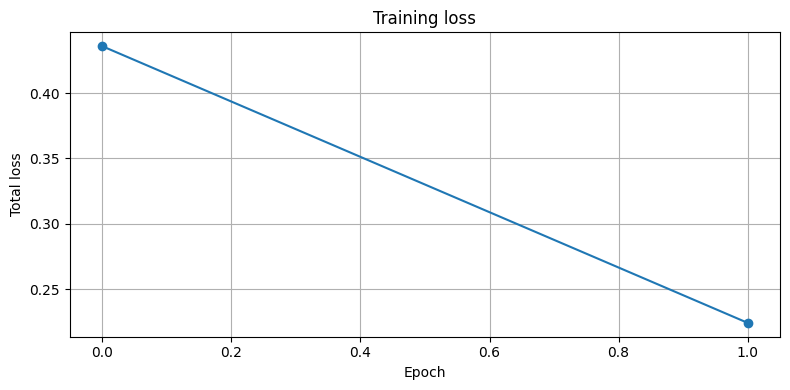

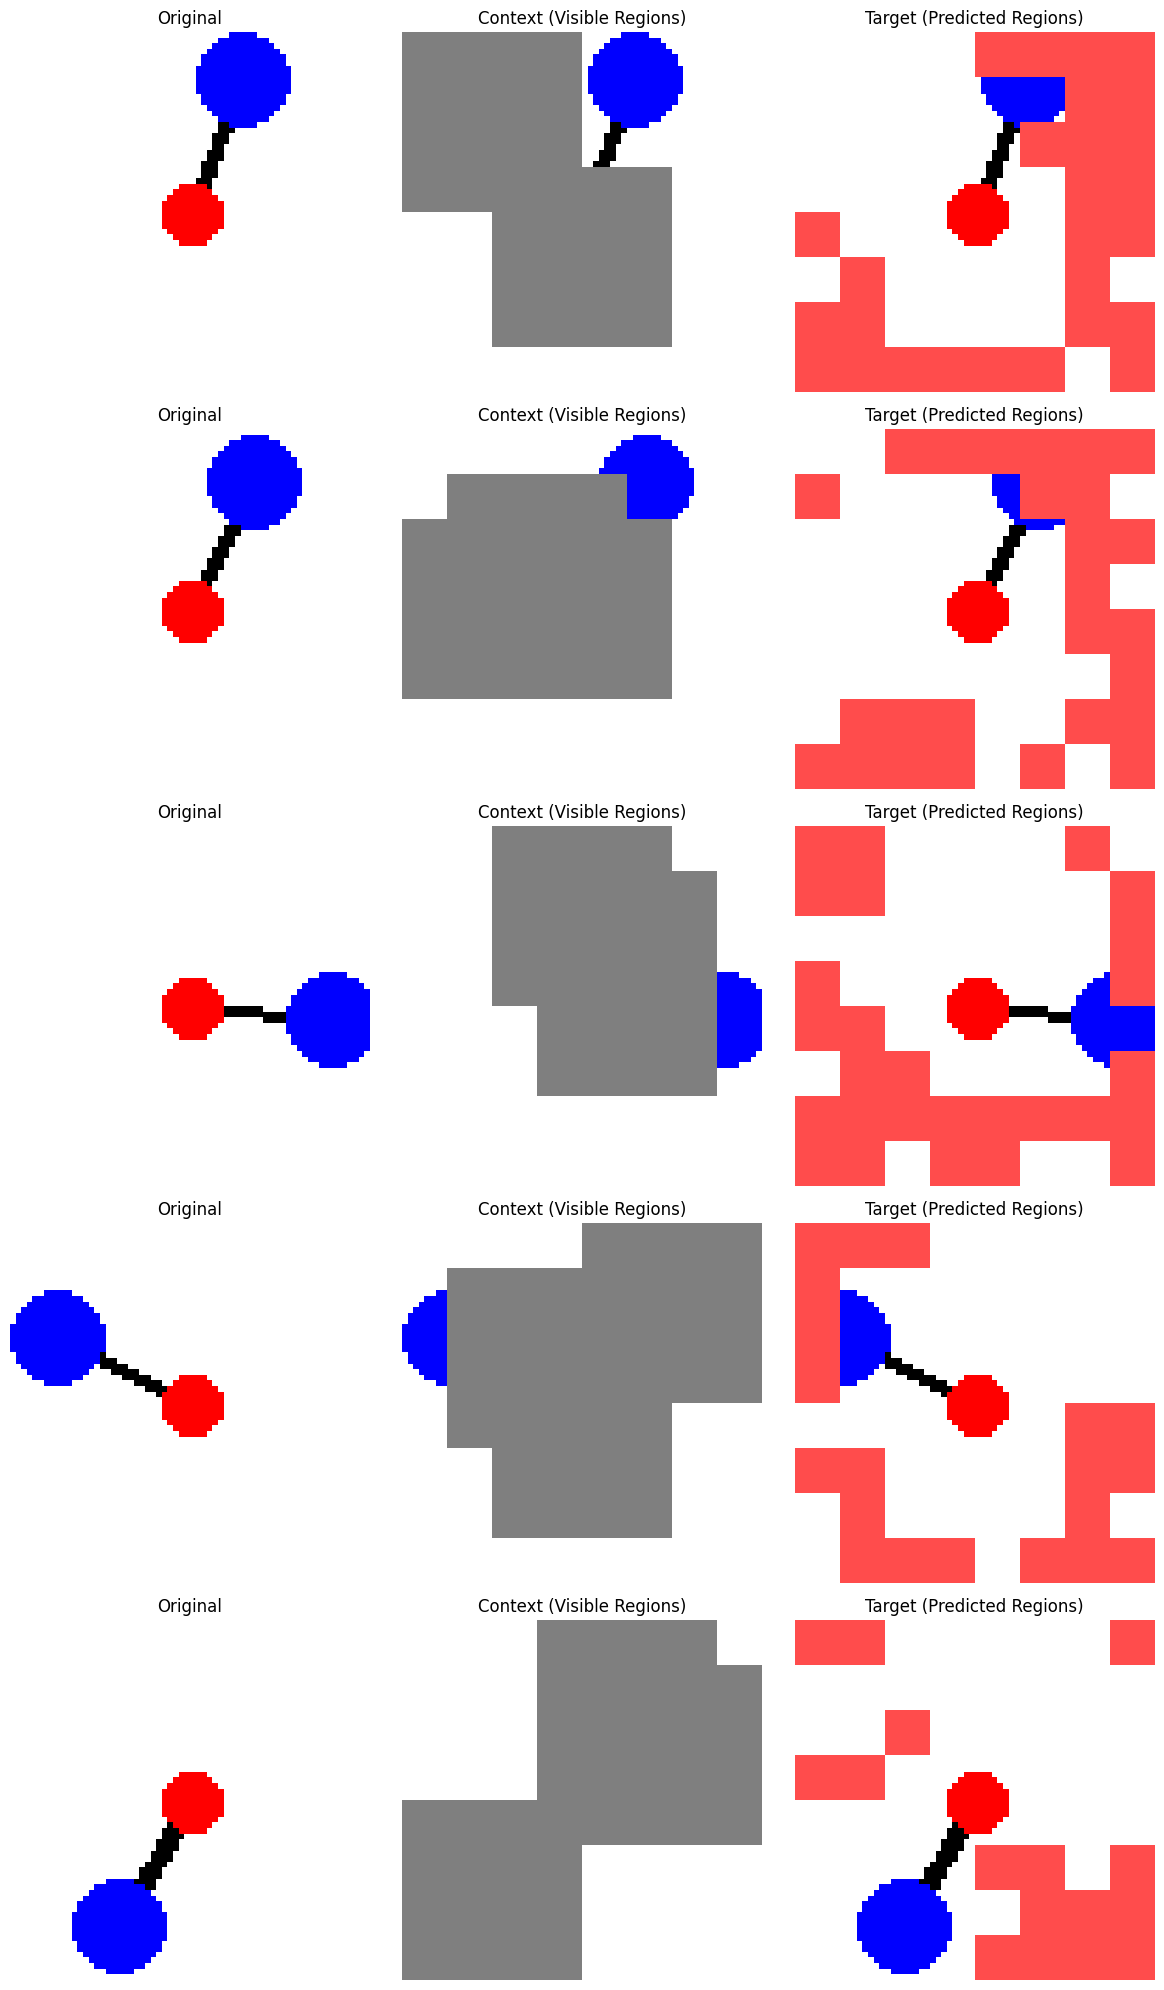

Training completed!


extract:   9%|▉         | 7/77 [00:01<00:14,  4.69it/s]


θ  R²=1.0000,  MSE=8.3748e-05
ω  R²=0.2419,  MSE=8.8211e+00


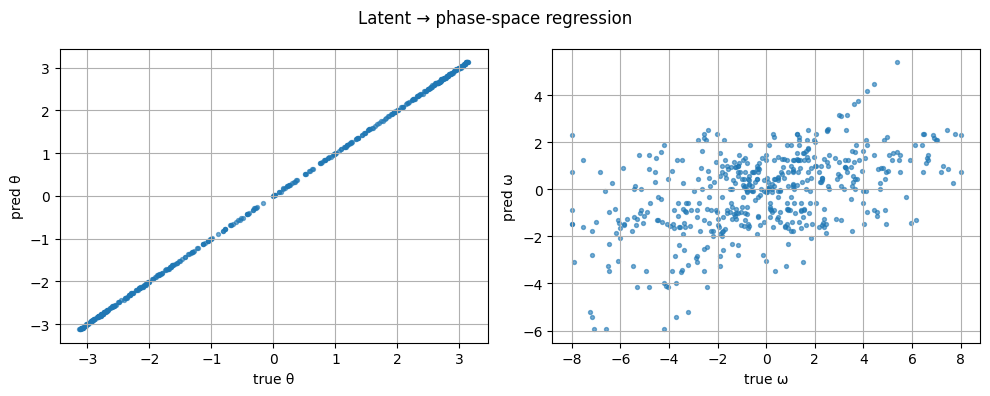

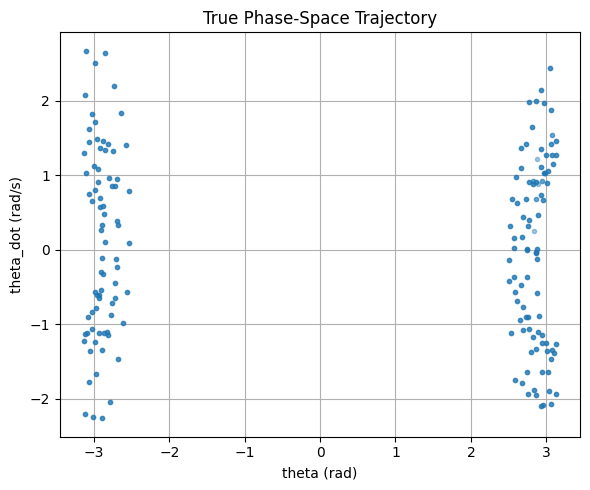

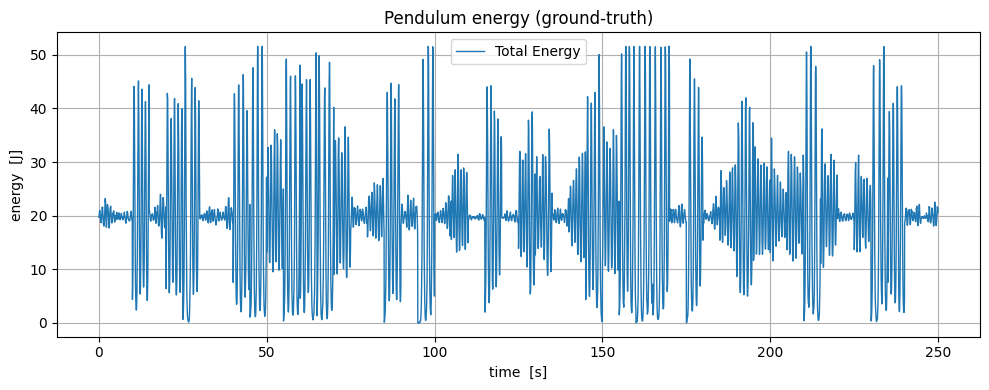

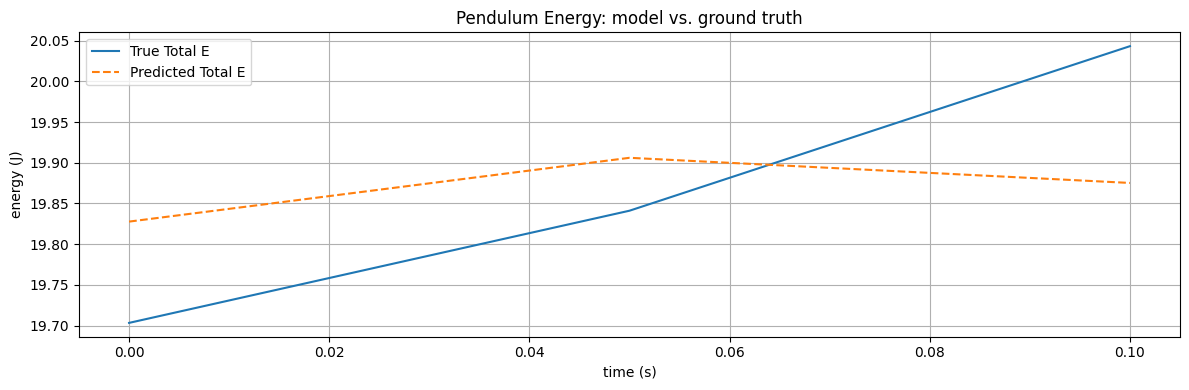

In [48]:
#!/usr/bin/env python3
# -------------------------------------------------------------
# Vision-JEPA + Lagrangian Neural Network on Pendulum (physics-correct)
# -------------------------------------------------------------

# ------------------------------------------------------------------
# 0 · Reproducibility & Device
# ------------------------------------------------------------------
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Data Collection / Preparation
# ============================
class PendulumDataset(Dataset):
    """
    Returns image *sequences* of length `seq_len` (T,C,H,W) and the
    corresponding (theta, omega) sequence (T,2).

    This allows the LNN to compute a proper Euler–Lagrange residual.
    """
    def __init__(
        self,
        num_episodes: int = 100,
        episode_length: int = 200,
        img_size: int = 64,
        seq_len: int = 3,
        transform=None,
    ):
        assert seq_len >= 2, "seq_len must be ≥ 2 for physics loss"
        self.img_size = img_size
        self.seq_len  = seq_len
        self.transform = transform

        self.frames  : list[np.ndarray] = []  # flattened RGB images
        self.states  : list[tuple[float,float]] = []  # flattened (θ, ω)
        self.indices : list[int] = []  # sample-idx -> start idx of window

        self._generate(num_episodes, episode_length)

    # -------------- synthetic pendulum renderer ------------------
    def _render_pendulum(self, theta: float) -> np.ndarray:
        L   = self.img_size * 0.4
        cx  = cy = self.img_size // 2
        ex  = int(cx + L * np.sin(theta))
        ey  = int(cy + L * np.cos(theta))

        img = Image.new("RGB", (self.img_size, self.img_size), "white")
        drw = ImageDraw.Draw(img)
        drw.line([(cx, cy), (ex, ey)], fill="black", width=3)
        drw.ellipse([(cx-5, cy-5), (cx+5, cy+5)], fill="red")
        drw.ellipse([(ex-8, ey-8), (ex+8, ey+8)], fill="blue")
        return np.asarray(img).copy()  

    # -------------- generate roll-outs ---------------------------
    def _generate(self, n_episodes: int, epi_len: int):
        print("Generating pendulum trajectories …")
        env = gym.make("Pendulum-v1")

        for _ in tqdm(range(n_episodes)):
            obs, _   = env.reset()
            theta    = np.arctan2(obs[1], obs[0])

            ep_imgs   : list[np.ndarray] = []
            ep_states : list[tuple[float,float]] = []

            for _ in range(epi_len):
                action = env.action_space.sample()
                obs, _, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

                theta = np.arctan2(obs[1], obs[0])
                omega = float(obs[2])

                ep_imgs.append(self._render_pendulum(theta))
                ep_states.append((theta, omega))

            # slide a window of length seq_len
            for t0 in range(0, len(ep_imgs) - self.seq_len + 1):
                self.indices.append(len(self.frames) + t0)

            self.frames.extend(ep_imgs)
            self.states.extend(ep_states)

        env.close()
        print(f"Created {len(self.indices)} windows (seq_len={self.seq_len})")

    # -------------- Dunder methods -------------------------------
    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        start = self.indices[idx]
        end   = start + self.seq_len

        imgs = [
            torch.from_numpy(self.frames[i]).float().permute(2, 0, 1) / 255.0
            for i in range(start, end)
        ]
        imgs = torch.stack(imgs)            # (T,C,H,W)

        states = torch.tensor(
            self.states[start:end], dtype=torch.float32
        )                                    # (T,2)  θ, ω

        if self.transform is not None:
            imgs = self.transform(imgs)

        return imgs, states

# ============================
# 2. V-JEPA backbone
# ============================
class PatchEmbed(nn.Module):
    """Image → patch embeddings"""
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=384):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj      = nn.Conv2d(in_chans, embed_dim,
                                   kernel_size=patch_size,
                                   stride=patch_size)
    def forward(self, x):
        x = self.proj(x)                     # (B,embed,H',W')
        x = x.flatten(2).transpose(1, 2)     # (B,N,embed)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_ratio):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                embed_dim,
                num_heads,
                int(embed_dim * mlp_ratio),
                batch_first=True,
                norm_first=True
            ) for _ in range(depth)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MaskingStrategy:
    """Block + random masking identical to original V-JEPA impl."""
    def __init__(self, num_patches, mask_ratio=0.75, block_size=4):
        self.N  = num_patches
        self.r  = mask_ratio
        self.bs = block_size

    def random_masking(self, B):
        n_keep = int(self.N * (1 - self.r))
        noise  = torch.rand(B, self.N, device=device)
        ids    = torch.argsort(noise, dim=1)
        restore= torch.argsort(ids , dim=1)
        mask   = torch.ones(B, self.N, device=device)
        mask[:, :n_keep] = 0
        mask   = torch.gather(mask, 1, restore)
        return mask.bool()

    def block_masking(self, B):
        grid  = int(np.sqrt(self.N))
        masks = torch.zeros(B, self.N, device=device)
        n_blk = int((self.N * self.r) / (self.bs ** 2))
        for b in range(B):
            for _ in range(n_blk):
                h0 = np.random.randint(0, grid - self.bs + 1)
                w0 = np.random.randint(0, grid - self.bs + 1)
                for h in range(h0, h0 + self.bs):
                    for w in range(w0, w0 + self.bs):
                        masks[b, h * grid + w] = 1
        return masks.bool()

class VJEPA(nn.Module):
    """
    Vision-based Joint Embedding Predictive Architecture
    (unchanged naming; context / target encoders etc.)
    """
    def __init__(
        self,
        img_size=64,
        patch_size=8,
        in_chans=3,
        embed_dim=384,
        depth=6,
        num_heads=6,
        mlp_ratio=4.0,
        prediction_head_dim=192,
    ):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.num_patches = self.patch_embed.n_patches
        self.pos_embed   = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        self.context_encoder = TransformerEncoder(
            embed_dim, depth, num_heads, mlp_ratio
        )
        self.target_encoder  = TransformerEncoder(
            embed_dim, depth, num_heads, mlp_ratio
        )

        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, prediction_head_dim),
            nn.GELU(),
            nn.Linear(prediction_head_dim, embed_dim)
        )

        self.masking = MaskingStrategy(self.num_patches)
        nn.init.normal_(self.pos_embed, std=0.02)

    # ---------- helpers ----------
    def forward_context(self, imgs, context_mask):
        x = self.patch_embed(imgs) + self.pos_embed  # (B,N,D)
        B, N, D = x.shape
        keep    = ~context_mask
        out     = torch.stack([
            F.pad(x[i][keep[i]], (0, 0, 0, N - keep[i].sum()))
            for i in range(B)
        ])
        return self.context_encoder(out)

    def forward_target(self, imgs, target_mask):
        x = self.patch_embed(imgs) + self.pos_embed
        B, N, D = x.shape
        out = torch.stack([
            F.pad(x[i][target_mask[i]], (0, 0, 0, N - target_mask[i].sum()))
            for i in range(B)
        ])
        return self.target_encoder(out)

    # ---------- main forward ----------
    def forward(self, imgs):
        """
        Returns:
            loss  : MSE between predictor(ctx) and target_feats
            pred  : predicted embeddings
            target: target embeddings
        """
        B = imgs.size(0)
        cmask = self.masking.block_masking(B)
        tmask = self.masking.random_masking(B) & ~cmask

        ctx_feats = self.forward_context(imgs, cmask)
        with torch.no_grad():
            tgt_feats = self.forward_target(imgs, tmask)

        pred = self.predictor(ctx_feats)
        loss = F.mse_loss(pred, tgt_feats)

        return loss, pred, tgt_feats

# ============================
# 3. Lagrangian Neural Network
# ============================
class LNN(nn.Module):
    """
    Minimal PyTorch port of Miles Cranmer's LNN.
    Learns scalar L(q,v); physics loss is Euler–Lagrange residual.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, qv):                     # (B,2d) → scalar L
        return self.net(qv)

    def lagrangian_residual(self, q, v, dt=0.01):
        """
        q, v : (B, T, d) tensors with T ≥ 2.
        Returns mean-squared Euler–Lagrange residual over (B,T-1,d).
        """
        B, T, d = q.shape
        z   = torch.cat([q, v], dim=-1).reshape(B*T, -1).requires_grad_(True)
        L   = self.forward(z).sum()
        dLd = torch.autograd.grad(L, z, create_graph=True)[0]
        dLdq, dLdv = dLd.split(d, dim=-1)
        dLdq = dLdq.view(B, T, d)
        dLdv = dLdv.view(B, T, d)

        ddt_dLdv = (dLdv[:, 1:] - dLdv[:, :-1]) / dt  # (B,T-1,d)
        residual = ddt_dLdv - dLdq[:, :-1]           # Euler–Lagrange
        return (residual ** 2).mean()

# ============================
# 4. Training Function
# ============================
def train_vjepa(
    model,
    theta_head,
    lnn_net,
    train_loader,
    optimizer,
    num_epochs=10,
    log_interval=10,
    lambda_phys=1e-3,
    lambda_sup=1e-2,
):
    model.train()
    theta_head.train()
    lnn_net.train()
    losses = []

    print("Starting training …")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for step, (imgs_seq, states_seq) in enumerate(
            tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        ):
            imgs_seq   = imgs_seq.to(device)    # (B,T,C,H,W)
            theta_seq  = states_seq[:, :, 0:1].to(device)  # (B,T,1)
            omega_seq  = states_seq[:, :, 1:2].to(device)  # (B,T,1)

            # ----- JEPA loss on first frame only -----
            imgs0 = imgs_seq[:, 0]               # (B,C,H,W)
            loss_jepa, _, _ = model(imgs0)

            # ----- latent → (θ̂, ω̂) (single frame) -----
            lat = model.patch_embed(imgs0) + model.pos_embed  # (B,N,D)
            lat = model.context_encoder(lat)                   # (B,N,D)
            z   = lat.mean(dim=1)                              # (B,D)
            theta_hat, omega_hat = theta_head(z).split(1, dim=1)

            # ----- physics loss on true trajectory -----
            phys_loss = lnn_net.lagrangian_residual(theta_seq, omega_seq)

            # ----- optional supervised θ loss (t=0) -----
            sup_loss = F.mse_loss(theta_hat, theta_seq[:, 0])

            # ----- total -----
            loss = (
                loss_jepa
                + lambda_phys * phys_loss
                + lambda_sup  * sup_loss
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if step % log_interval == 0:
                tqdm.write(
                    f"step {step:04d} | jepa {loss_jepa.item():.4f} "
                    f"| phys {phys_loss.item():.4f}"
                )

        avg = epoch_loss / len(train_loader)
        losses.append(avg)
        print(f"Epoch {epoch+1} avg loss {avg:.4f}")
    return losses

def visualize_reconstructions(model, dataset, num_samples=5):
    """Show original, context-masked and target-masked frames."""
    model.eval()

    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    seq, _ = next(iter(loader))          # seq: (B,T,C,H,W)
    imgs   = seq[:, 0].to(device)        # take frame t=0 → (B,C,H,W)

    with torch.no_grad():
        B = imgs.size(0)
        context_mask = model.masking.block_masking(B)
        target_mask  = model.masking.random_masking(B) & ~context_mask
        context_feats = model.forward_context(imgs, context_mask)
        pred = model.predictor(context_feats)
        
    # Visualize the results
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        # Masked image (context)
        plt.subplot(num_samples, 3, i * 3 + 2)
        masked_img = imgs[i].clone().cpu()

        grid_size = int(np.sqrt(model.num_patches))
        mask_reshaped = context_mask[i].reshape(1, 1, grid_size, grid_size).float()
        mask_upsampled = F.interpolate(
            mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            masked_img[c][mask_upsampled.bool()] = 0.5  # Gray out masked areas

        plt.imshow(masked_img.permute(1, 2, 0).numpy())
        plt.title("Context (Visible Regions)")
        plt.axis('off')

        # Target image (highlight predicted regions)
        plt.subplot(num_samples, 3, i * 3 + 3)
        target_img = imgs[i].clone().cpu()

        target_mask_reshaped = target_mask[i].reshape(1, 1, grid_size, grid_size).float()
        target_mask_upsampled = F.interpolate(
            target_mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            if c == 0:  # Red channel
                target_img[c][target_mask_upsampled.bool()] = 1.0
            else:
                target_img[c][target_mask_upsampled.bool()] = 0.3

        plt.imshow(target_img.permute(1, 2, 0).numpy())
        plt.title("Target (Predicted Regions)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('vjepa_reconstructions.png')
    plt.show()
    
# ============================
# 5. Simple loss plot helper
# ============================
def plot_training_loss(loss_list):
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Total loss")
    plt.title("Training loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================
# 7. Main
# ============================
def main():
    # ---- config ----
    batch_size    = 32
    img_size      = 64
    patch_size    = 8
    embed_dim     = 384
    depth         = 6
    num_heads     = 6
    pred_head_dim = 192
    learning_rate = 1e-4
    num_epochs    = 2
    seq_len       = 3

    # ---- dataset & loader ----
    dataset = PendulumDataset(
        num_episodes=50,
        episode_length=100,
        img_size=img_size,
        seq_len=seq_len
    )
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )

    # ---- models ----
    model = VJEPA(
        img_size         = img_size,
        patch_size       = patch_size,
        in_chans         = 3,
        embed_dim        = embed_dim,
        depth            = depth,
        num_heads        = num_heads,
        mlp_ratio        = 4.0,
        prediction_head_dim = pred_head_dim,
    ).to(device)

    theta_head = nn.Linear(embed_dim, 2).to(device)
    lnn_net    = LNN(input_dim=2, hidden_dim=256).to(device)

    # ---- optimiser ----
    optimizer = optim.AdamW(
        list(model.parameters())
        + list(theta_head.parameters())
        + list(lnn_net.parameters()),
        lr=learning_rate)
    
    # ───────────────────────────
    # 6 · Training
    # ───────────────────────────
    losses = train_vjepa(
        model, theta_head, lnn_net,
        train_loader, optimizer,
        num_epochs=num_epochs
    )

    plot_training_loss(losses)
    visualize_reconstructions(model, dataset)

    # save checkpoint
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, "vjepa_pendulum_final.pt")

    print("Training completed!")
    analyze_vjepa_latent_phase_relation(model, dataset)
    plot_true_phase_space(dataset)
    plot_energy_conservation(dataset)   # uncomment if desired
    plot_energy_model_vs_truth(
    model,            # your trained VJEPA
    theta_head,       # trained latent→(θ,ω) layer
    dataset,
    win_idx=0         # pick any window index you like
)


if __name__ == "__main__":
    main()